In [1]:
import scipy.io
data = scipy.io.loadmat('exp/datasets/PICMUS/Simulation_Data/picmus_simu1.mat')
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'data'])


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert
import scipy.io

# Load the data
data = scipy.io.loadmat('exp/datasets/PICMUS/Simulation_Data/picmus_simu1.mat')
rf = data['data'].astype(np.float64)
print('RF shape:', rf.shape)
print('RF range: min =', np.min(rf), ', max =', np.max(rf))

RF shape: (609, 387)
RF range: min = 0.0030248514376580715 , max = 17.525310516357422


(512, 387)


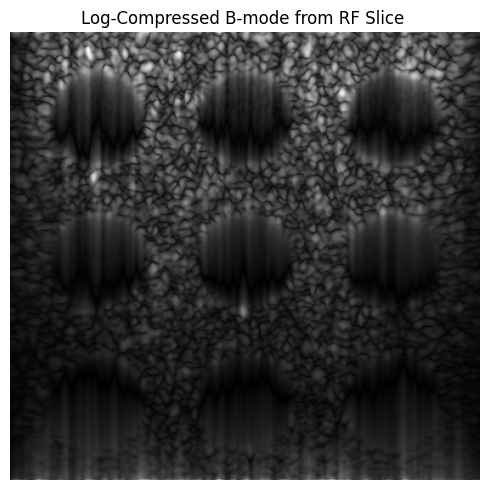

In [8]:
import numpy as np
import scipy.io
from scipy.signal import hilbert
import matplotlib.pyplot as plt

# Load the .mat file
carotid_data = scipy.io.loadmat('exp/datasets/PICMUS/Simulation_Data/picmus_simu1.mat')
rf_data = carotid_data['data']

# Log compression baseline
LogB = 120

# Extract 512 rows starting from index 1000
rf_section = rf_data[80:80+512, :]

print(rf_section.shape)

# Apply Hilbert transform along depth axis
env = np.abs(hilbert(rf_section, axis=0))

# Log compression
log_env = np.log(env + LogB)

# Plot B-mode image
plt.figure(figsize=(5, 5))
plt.imshow(log_env, cmap='gray', aspect='auto')
plt.title('Log-Compressed B-mode from RF Slice ')
plt.axis('off')
plt.tight_layout()
plt.show()

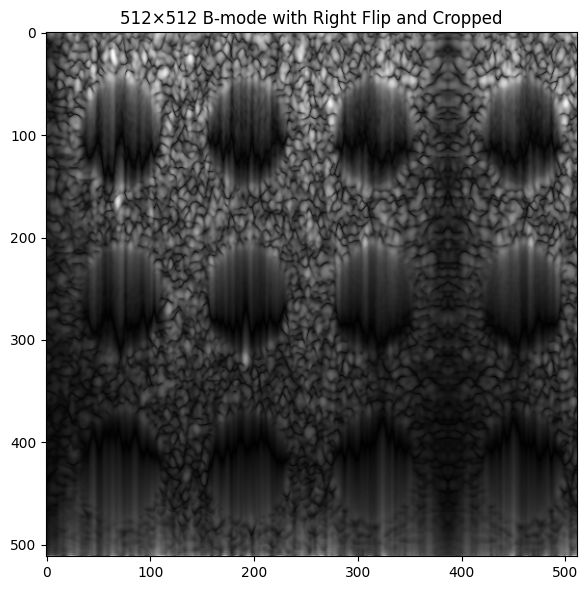

In [19]:
H, W = rf_section.shape

# Step 1: Copy original into new 512×512 matrix
rf_filled = np.zeros((512, 512), dtype=rf_section.dtype)
rf_filled[:, :W] = rf_section

# Step 2: Fill remaining with flipped rightmost part
fill_width = 512 - W
rf_filled[:, W:] = np.fliplr(rf_section[:, -fill_width:])

# Step 3: Hilbert transform + log compression
LogB = 10
env = np.abs(hilbert(rf_filled, axis=0))
log_env = np.log(env + LogB)

# Plot the final 512×512 result
plt.figure(figsize=(6, 6))
plt.imshow(log_env, cmap='gray', aspect='auto')
plt.title('512×512 B-mode with Right Flip and Cropped')
plt.axis('on')
plt.tight_layout()
plt.show()


In [12]:
rf_filled.shape

(512, 512)

In [13]:
print('RF range: min =', np.min(rf_filled), ', max =', np.max(rf_filled))

RF range: min = 0.0030248514 , max = 15.817394


In [14]:
rfn = rf_filled / np.max(np.abs(rf_filled))
print('RF range: min =', np.min(rfn), ', max =', np.max(rfn))

RF range: min = 0.00019123575 , max = 1.0


In [15]:
import scipy.io

# Save only the 512×512 RF matrix
scipy.io.savemat('exp/datasets/PICMUS/Simulation_Data/picmus_simu1_rf_ddrm.mat', {'data': rf_filled})
scipy.io.savemat('exp/datasets/PICMUS/Simulation_Data/picmus_simu1_rfn_ddrm.mat', {'data': rfn})

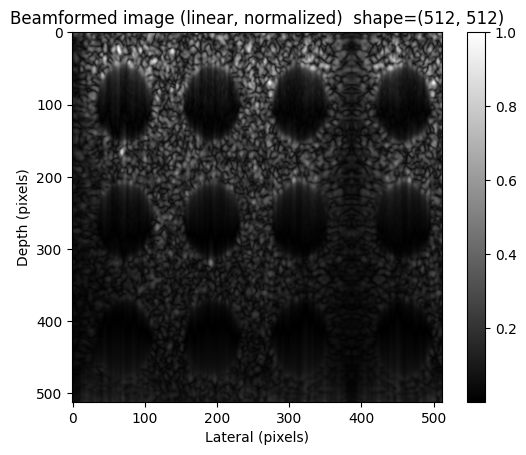

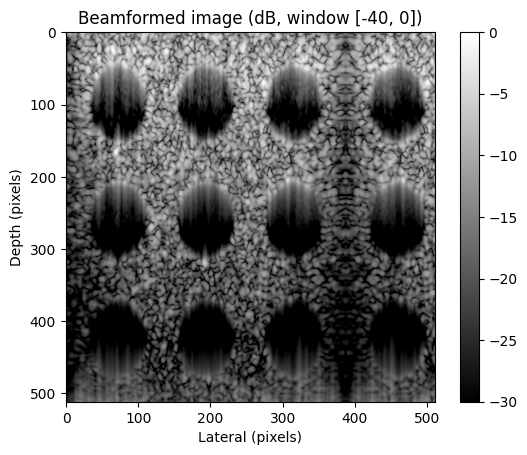

In [20]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

# Load the beamformed image
mat_path = "exp/datasets/PICMUS/Simulation_Data/picmus_simu1_rfn_ddrm.mat"
mat = sio.loadmat(mat_path)
img = mat.get("data")
if img is None:
    raise ValueError("Could not find variable 'data' in exp_data.mat")

# Ensure float
img = np.asarray(img, dtype=np.float32)

# Linear magnitude view (normalized)
lin = np.abs(img)
lin_norm = lin / (lin.max() + 1e-12)

# dB view in [-40, 0] dB
db = 20.0 * np.log10(lin_norm + 1e-12)
vmin, vmax = -30.0, 0.0

# Show linear magnitude
plt.figure()
plt.imshow(lin_norm, cmap="gray", origin="upper", aspect="equal")
plt.colorbar()
plt.title(f"Beamformed image (linear, normalized)  shape={img.shape}")
plt.xlabel("Lateral (pixels)")
plt.ylabel("Depth (pixels)")
plt.show()

# Show dB compressed image
plt.figure()
plt.imshow(db, cmap="gray", origin="upper", aspect="equal", vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title("Beamformed image (dB, window [-40, 0])")
plt.xlabel("Lateral (pixels)")
plt.ylabel("Depth (pixels)")
plt.show()


### Loading and Visualize PSF

In [21]:
# Load the estimated PSF from the uploaded psf.mat file
psf_mat_path = 'exp/datasets/PICMUS/Simulation_Data/psf_simu1_oleg.mat'
psf_data = scipy.io.loadmat(psf_mat_path)

# List keys to identify the PSF variable
psf_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'cropped_psf'])

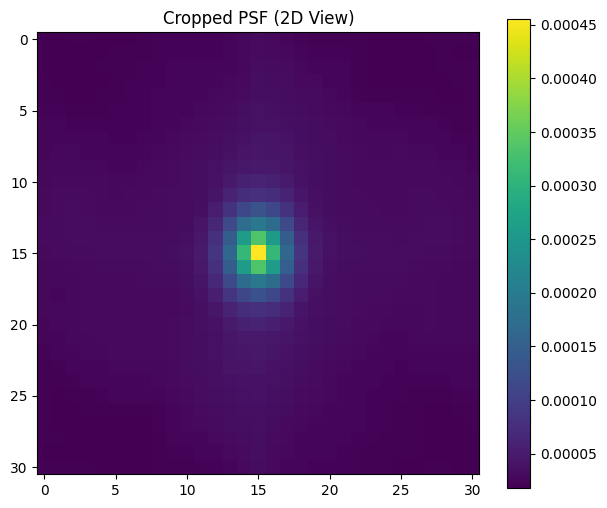

In [22]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the cropped PSF from the uploaded .mat file
mat = scipy.io.loadmat('exp/datasets/PICMUS/Simulation_Data/psf_simu1_oleg.mat')
cropped_psf = mat['cropped_psf']

# Plot the 2D image
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(cropped_psf, cmap='viridis')
plt.title('Cropped PSF (2D View)')
plt.axis('image')
plt.colorbar()


plt.tight_layout()
plt.show()


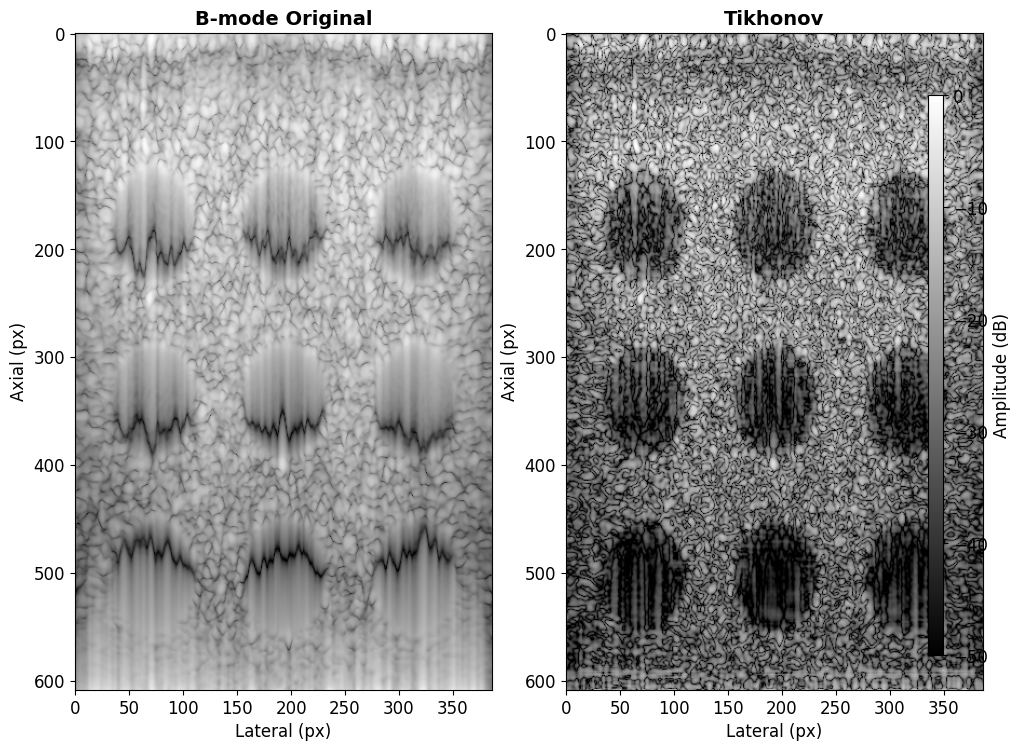

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import hilbert, correlate
import warnings
warnings.filterwarnings('ignore')

# 1. Load raw RF data
data = loadmat('exp/datasets/PICMUS/Simulation_Data/picmus_simu1.mat')
rf = data['data']
rfn = rf / np.max(np.abs(rf))  # normalized RF

# 2. Tikhonov restoration (Wiener filter)
psf_data = loadmat('exp/datasets/PICMUS/Simulation_Data/psf_simu1_oleg.mat')
H = psf_data['cropped_psf']
h = H / np.sum(np.abs(H))
Mh, Nh = H.shape
center = np.round(np.array([Mh, Nh])/2).astype(int)

pad_h = np.pad(h, ((0, rf.shape[0]-Mh), (0, rf.shape[1]-Nh)), mode='constant')
pad_h = np.roll(pad_h, 1-center[0], axis=0)
pad_h = np.roll(pad_h, 1-center[1], axis=1)

D = np.fft.fft2(pad_h)
SNR_val = 1000  # ~60 dB
VivoTK = np.fft.ifft2(np.fft.fft2(rfn) * np.conj(D) / (SNR_val**(-1) + np.conj(D)*D)).real

# 3. Envelope detection and log compression
M, N = rf.shape
rf = rf[:M, :N]
VivoTK = VivoTK[:M, :N]

# Raw data processing
env_raw = np.abs(hilbert(rf, axis=0))
env_raw = env_raw / np.max(env_raw)
bmode_raw = 20 * np.log10(env_raw + np.finfo(float).eps)
bmode_raw = np.maximum(bmode_raw, -50)

# Tikhonov processing
env_tikh = np.abs(VivoTK)
env_tikh = env_tikh / np.max(env_tikh)
bmode_tikh = 20 * np.log10(env_tikh + np.finfo(float).eps)
bmode_tikh = np.maximum(bmode_tikh, -50)



# 5. Visualization
fig = plt.figure(figsize=(10, 8))
fig.canvas.manager.set_window_title('B-mode Comparison')

titles = ['B-mode Original', 'Tikhonov']
images = [bmode_raw, bmode_tikh]

for i in range(2):
    ax = plt.subplot(1, 2, i+1)
    im = ax.imshow(images[i], cmap='gray', vmin=-50, vmax=0, aspect='equal')
    ax.set_title(titles[i], fontsize=14, fontweight='bold')
    ax.set_xlabel('Lateral (px)', fontsize=12)
    ax.set_ylabel('Axial (px)', fontsize=12)
    ax.tick_params(labelsize=12)

plt.subplots_adjust(right=0.99999)
cbar_ax = fig.add_axes([0.93, 0.15, 0.015, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Amplitude (dB)', fontsize=12)
cbar.ax.tick_params(labelsize=12)

plt.tight_layout()
plt.show()


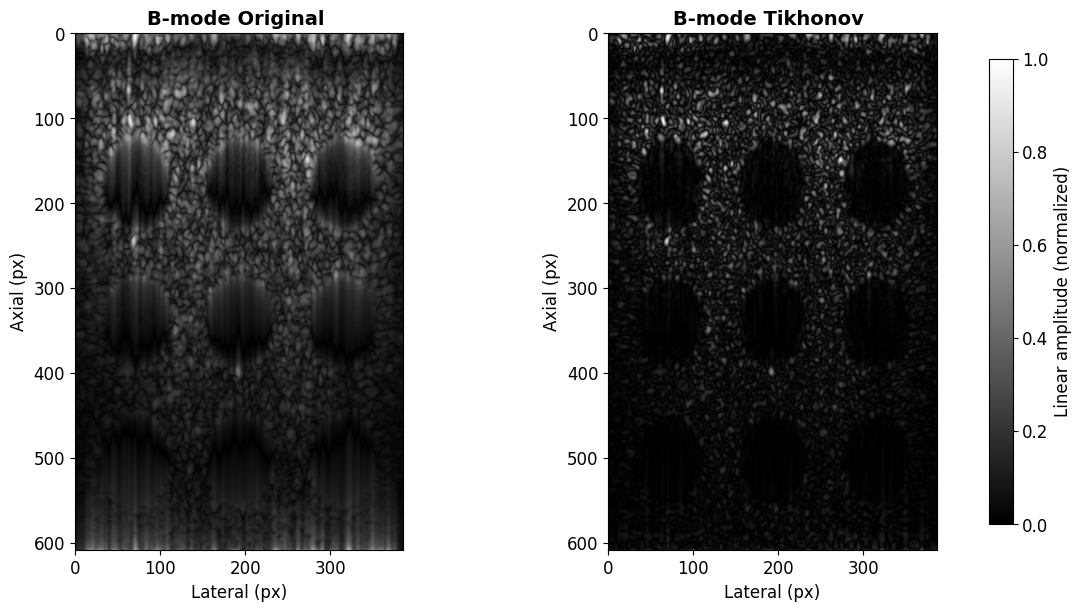

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import hilbert
import warnings
warnings.filterwarnings('ignore')

# ------------------------------
# 1. Load raw RF data
# ------------------------------
data = loadmat('exp/datasets/PICMUS/Simulation_Data/picmus_simu1.mat')
rf = data['data'].astype(float)
rfn = rf / np.max(np.abs(rf))  # normalized RF

# ------------------------------
# 2. Tikhonov restoration (Wiener filter) with your new PSF
# ------------------------------
psf_data = loadmat('exp/datasets/PICMUS/Simulation_Data/psf_simu1_oleg.mat')
H = psf_data['cropped_psf'].astype(float)
h = H / np.sum(np.abs(H))
Mh, Nh = H.shape
center = np.round(np.array([Mh, Nh]) / 2).astype(int)

pad_h = np.pad(h, ((0, rf.shape[0]-Mh), (0, rf.shape[1]-Nh)), mode='constant')
pad_h = np.roll(pad_h, 1-center[0], axis=0)
pad_h = np.roll(pad_h, 1-center[1], axis=1)

D = np.fft.fft2(pad_h)
SNR_val = 300 # ~54 dB
VivoTK = np.fft.ifft2(np.fft.fft2(rfn) * np.conj(D) / (SNR_val**(-1) + np.conj(D)*D)).real

# Trim (already same size)
M, N = rf.shape
rf = rf[:M, :N]
VivoTK = VivoTK[:M, :N]

# ------------------------------
# 3. Visualization WITHOUT log
# ------------------------------
# Envelope (linear) and normalize 0..1
env_raw = np.abs(hilbert(rf, axis=0))
env_raw /= (env_raw.max() + 1e-12)

env_tikh = np.abs(VivoTK)
env_tikh /= (env_tikh.max() + 1e-12)

# Side-by-side with shared colorbar
fig, axes = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
titles = ['B-mode Original ', 'B-mode Tikhonov ']
images = [env_raw, env_tikh]

for ax, im, title in zip(axes, images, titles):
    imh = ax.imshow(im, cmap='gray', vmin=0, vmax=1, aspect='equal', origin='upper')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Lateral (px)', fontsize=12)
    ax.set_ylabel('Axial (px)', fontsize=12)
    ax.tick_params(labelsize=12)

cbar = fig.colorbar(imh, ax=axes.ravel().tolist(), shrink=0.9)
cbar.set_label('Linear amplitude (normalized)', fontsize=12)
cbar.ax.tick_params(labelsize=12)

plt.show()


Contrast improvement: 1.34x
Regularization parameter: 5.0e-04


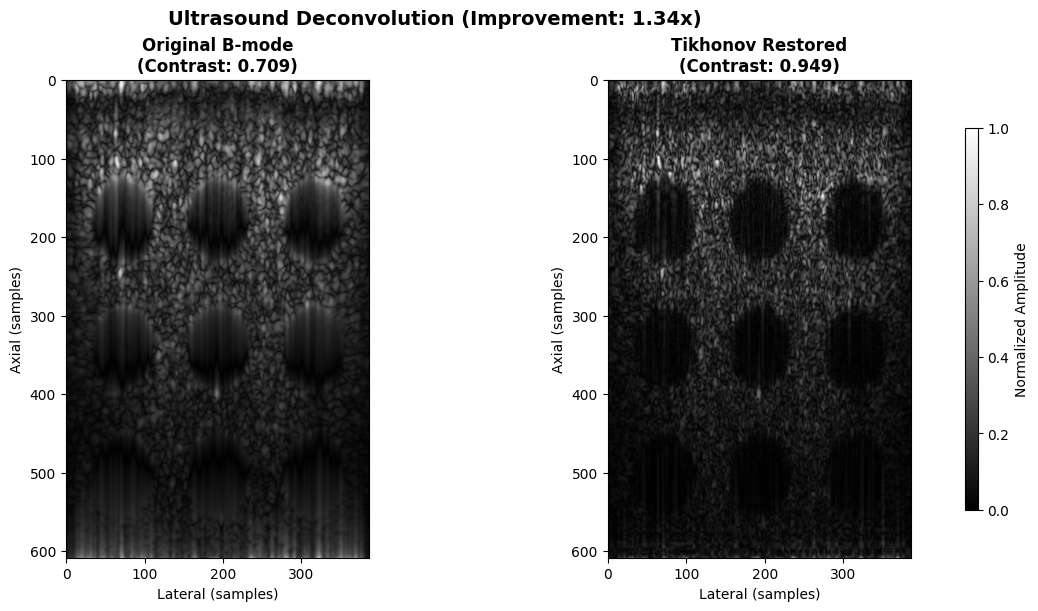

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import hilbert
import warnings
warnings.filterwarnings('ignore')

def tikhonov_deconvolution(rf_data, psf, reg_param=1e-3):
    """
    Tikhonov regularized deconvolution for ultrasound RF data
    
    Args:
        rf_data: Input RF data (2D array)
        psf: Point spread function
        reg_param: Regularization parameter (smaller = less smoothing)
    """
    # Pad PSF to match RF data size
    pad_psf = np.pad(psf, ((0, rf_data.shape[0]-psf.shape[0]), 
                           (0, rf_data.shape[1]-psf.shape[1])), mode='constant')
    
    # Center PSF (shift zero-frequency to origin)
    center = np.array(psf.shape) // 2
    pad_psf = np.roll(pad_psf, -center, axis=(0,1))
    
    # Frequency domain deconvolution
    H = np.fft.fft2(pad_psf)
    RF_fft = np.fft.fft2(rf_data)
    
    # Tikhonov filter: H* / (|H|^2 + λ)
    H_conj = np.conj(H)
    restored_fft = RF_fft * H_conj / (H_conj * H + reg_param)
    
    return np.fft.ifft2(restored_fft).real

def compute_contrast_metric(envelope):
    """Simple contrast metric: std/mean ratio"""
    return np.std(envelope) / (np.mean(envelope) + 1e-12)

# ------------------------------
# Load and preprocess data
# ------------------------------
# Load RF data
data = loadmat('exp/datasets/PICMUS/Simulation_Data/picmus_simu1.mat')
rf = data['data'].astype(float)
rf_norm = rf / np.max(np.abs(rf))

# Load PSF
psf_data = loadmat('exp/datasets/PICMUS/Simulation_Data/psf_simu1_oleg.mat')
psf = psf_data['cropped_psf'].astype(float)
psf = psf / np.sum(np.abs(psf))  # Normalize PSF

# ------------------------------
# Apply Tikhonov deconvolution
# ------------------------------
rf_restored = tikhonov_deconvolution(rf_norm, psf, reg_param=5e-4)

# ------------------------------
# Generate envelopes and compute metrics
# ------------------------------
env_original = np.abs(hilbert(rf_norm, axis=0))
env_restored = np.abs(hilbert(rf_restored, axis=0))

# Normalize envelopes
env_original /= env_original.max()
env_restored /= env_restored.max()

# Compute quality metrics
contrast_orig = compute_contrast_metric(env_original)
contrast_rest = compute_contrast_metric(env_restored)
improvement = contrast_rest / contrast_orig

print(f"Contrast improvement: {improvement:.2f}x")
print(f"Regularization parameter: {5e-4:.1e}")

# ------------------------------
# Visualization
# ------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)

titles = ['Original B-mode', 'Tikhonov Restored']
envelopes = [env_original, env_restored]

for ax, envelope, title in zip(axes, envelopes, titles):
    im = ax.imshow(envelope, cmap='gray', vmin=0, vmax=1, 
                   aspect='equal', origin='upper')
    ax.set_title(f'{title}\n(Contrast: {compute_contrast_metric(envelope):.3f})', 
                 fontsize=12, fontweight='bold')
    ax.set_xlabel('Lateral (samples)', fontsize=10)
    ax.set_ylabel('Axial (samples)', fontsize=10)

# Shared colorbar
cbar = fig.colorbar(im, ax=axes, shrink=0.8, aspect=30)
cbar.set_label('Normalized Amplitude', fontsize=10)

plt.suptitle(f'Ultrasound Deconvolution (Improvement: {improvement:.2f}x)', 
             fontsize=14, fontweight='bold')
plt.show()

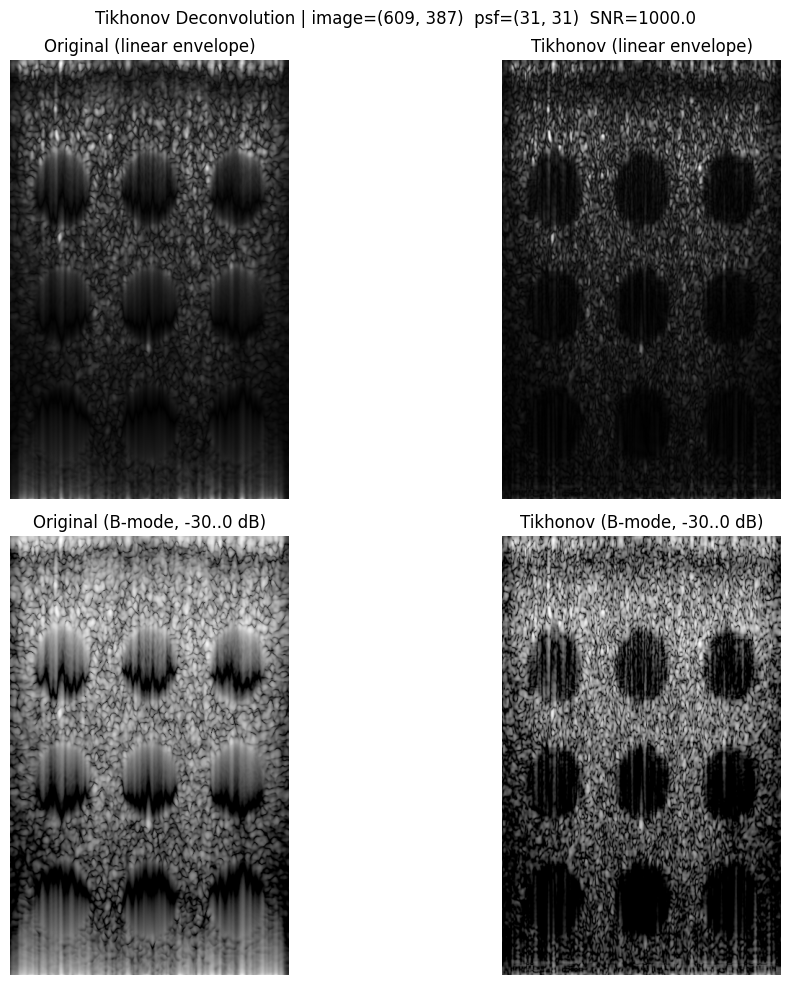

((609, 387), (31, 31), 1000.0)

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import hilbert

def load_first_2d(path, prefer=("data", "img", "image")):
    m = loadmat(path)
    for k in prefer:
        if k in m:
            arr = np.asarray(m[k])
            if arr.ndim >= 2:
                return np.squeeze(arr)
    keys = [k for k in m.keys() if not k.startswith("__")]
    for k in keys:
        arr = np.asarray(m[k])
        if arr.ndim >= 2:
            return np.squeeze(arr)
    raise ValueError(f"No 2D array found in {path}")

# Load image and PSF
img = load_first_2d("exp/datasets/PICMUS/Simulation_Data/picmus_simu1.mat").astype(float)
psf = load_first_2d("exp/datasets/PICMUS/Simulation_Data/psf_simu1_oleg.mat").astype(float)

# Normalize
img_n = img / (np.max(np.abs(img)) + 1e-12)
psf   = psf / (np.sum(np.abs(psf)) + 1e-12)

# Center-pad PSF to image size
Mh, Nh = psf.shape
M, N   = img_n.shape
pad_h = np.zeros_like(img_n)
pad_h[:Mh, :Nh] = psf
pad_h = np.roll(pad_h, -Mh//2, axis=0)
pad_h = np.roll(pad_h, -Nh//2, axis=1)

# Tikhonov
H = np.fft.fft2(pad_h)
Y = np.fft.fft2(img_n)
SNR_val = 1000.0
denom = (np.conjugate(H) * H) + (1.0 / SNR_val)
Xhat  = (np.conjugate(H) * Y) / denom
restored = np.fft.ifft2(Xhat).real

# Envelopes + B-mode
def envelope_linear(x):
    try:
        env = np.abs(hilbert(x, axis=0))
    except Exception:
        env = np.abs(x)
    return env / (env.max() + 1e-12)

def bmode_db(env, vmin=-30, vmax=0):
    db = 20*np.log10(env + 1e-12)
    return np.clip(db, vmin, vmax)

env_orig = envelope_linear(img)
env_tikh = envelope_linear(restored)
b_orig   = bmode_db(env_orig, vmin=-30, vmax=0)
b_tikh   = bmode_db(env_tikh, vmin=-30, vmax=0)

# Plot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
im0 = axes[0,0].imshow(env_orig, cmap="gray", vmin=0, vmax=1, origin="upper", aspect="equal")
axes[0,0].set_title("Original (linear envelope)"); axes[0,0].axis("off")
im1 = axes[0,1].imshow(env_tikh, cmap="gray", vmin=0, vmax=1, origin="upper", aspect="equal")
axes[0,1].set_title("Tikhonov (linear envelope)"); axes[0,1].axis("off")
#cbar0 = plt.colorbar(im1, ax=axes[0,:].ravel().tolist(), shrink=0.85); cbar0.set_label("Linear amplitude (normalized)")

im2 = axes[1,0].imshow(b_orig, cmap="gray", vmin=-30, vmax=0, origin="upper", aspect="equal")
axes[1,0].set_title("Original (B-mode, -30..0 dB)"); axes[1,0].axis("off")
im3 = axes[1,1].imshow(b_tikh, cmap="gray", vmin=-30, vmax=0, origin="upper", aspect="equal")
axes[1,1].set_title("Tikhonov (B-mode, -30..0 dB)"); axes[1,1].axis("off")
#cbar1 = plt.colorbar(im3, ax=axes[1,:].ravel().tolist(), shrink=0.85); cbar1.set_label("Amplitude (dB)")

plt.suptitle(f"Tikhonov Deconvolution | image={img.shape}  psf={psf.shape}  SNR={SNR_val}", fontsize=12)
plt.tight_layout()
plt.show()

(img.shape, psf.shape, SNR_val)


### DDRM

In [31]:
folder_name = "Picmus_Exp"

In [36]:
!python main.py --ni --config Deconv_picmus1.yml --doc imagenet_ood --timesteps 20 --eta 0.85 --etaB 1 --deg deblur_bccb --sigma_0 25 -i {folder_name}

Module path: /projects/minds/PDAS-M2-2025/DDPM
Current sys.path: ['/projects/minds/PDAS-M2-2025/Stable_DDRM', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '/home/pdas/.local/lib/python3.10/site-packages', '/usr/local/lib/python3.10/dist-packages', '/usr/local/lib/python3.10/dist-packages/nvfuser-0.1.4a0+d0bb811-py3.10-linux-x86_64.egg', '/usr/lib/python3/dist-packages', '/projects/minds/PDAS-M2-2025/DDPM']
File not found: /projects/minds/PDAS-M2-2025/DDPM/denoising_diffusion_pytorch.py
Import failed: No module named 'denoising_diffusion_pytorch'
INFO - main.py - 2025-08-27 19:00:12,079 - Using device: cuda
INFO - main.py - 2025-08-27 19:00:12,080 - Writing log file to exp/logs/imagenet_ood
INFO - main.py - 2025-08-27 19:00:12,080 - Exp instance id = 762431
INFO - main.py - 2025-08-27 19:00:12,080 - Exp comment = 
building dataset from exp/picmus.txt
read meta done
Start from 0
  0%|                                                     | 0/1 [00:00<

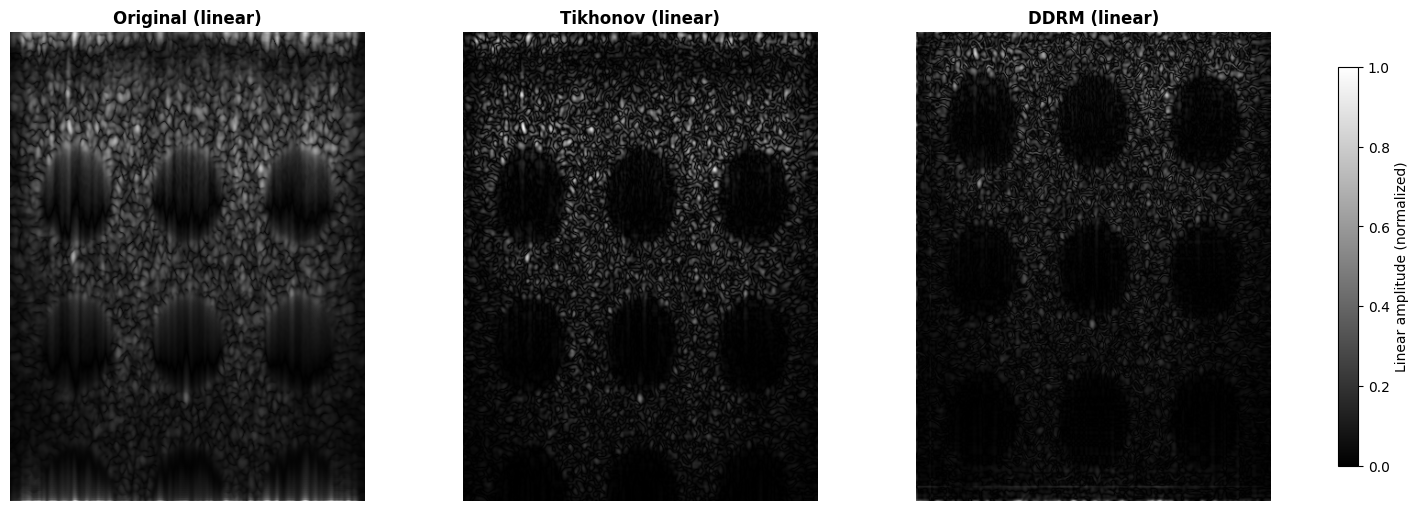

In [37]:
# 3) DDRM restoration (load & normalize per your snippet)
ddrm_data = loadmat('exp/image_samples/Picmus_Exp/0_-1.mat')
image = ddrm_data['image'] if 'image' in ddrm_data else ddrm_data[[k for k in ddrm_data if not k.startswith('__')][0]]
if image.ndim == 3:
    image = np.transpose(image, (1, 2, 0))
grayimage = np.mean(image, axis=2) if image.ndim == 3 else image
grayimage = grayimage / np.max(np.abs(grayimage))  # Normalization

# 4) Envelope detection (linear, no log) and crop to common size
M1, N1 = rf.shape
M2, N2 = VivoTK.shape
M3, N3 = grayimage.shape
Mmin, Nmin = min(M1, M2, M3), min(N1, N2, N3)

rf       = rf[:Mmin, :Nmin]
VivoTK   = VivoTK[:Mmin, :Nmin]
grayimage= grayimage[:Mmin, :Nmin]

env_raw = np.abs(hilbert(rf, axis=0));     env_raw /= (env_raw.max() + 1e-12)
env_tik = np.abs(VivoTK);                  env_tik /= (env_tik.max() + 1e-12)
env_ddr = np.abs(grayimage);               env_ddr /= (env_ddr.max() + 1e-12)

# 5) Side-by-side visualization (no log), shared colorbar
fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)
titles = ['Original (linear)', 'Tikhonov (linear)', 'DDRM (linear)']
for ax, im, t in zip(axes, [env_raw, env_tik, env_ddr], titles):
    imh = ax.imshow(im, cmap='gray', vmin=0, vmax=1, origin='upper', aspect='equal')
    ax.set_title(t, fontsize=12, fontweight='bold')
    ax.axis('off')
cbar = fig.colorbar(imh, ax=axes.ravel().tolist(), shrink=0.85)
cbar.set_label('Linear amplitude (normalized)')
plt.show()


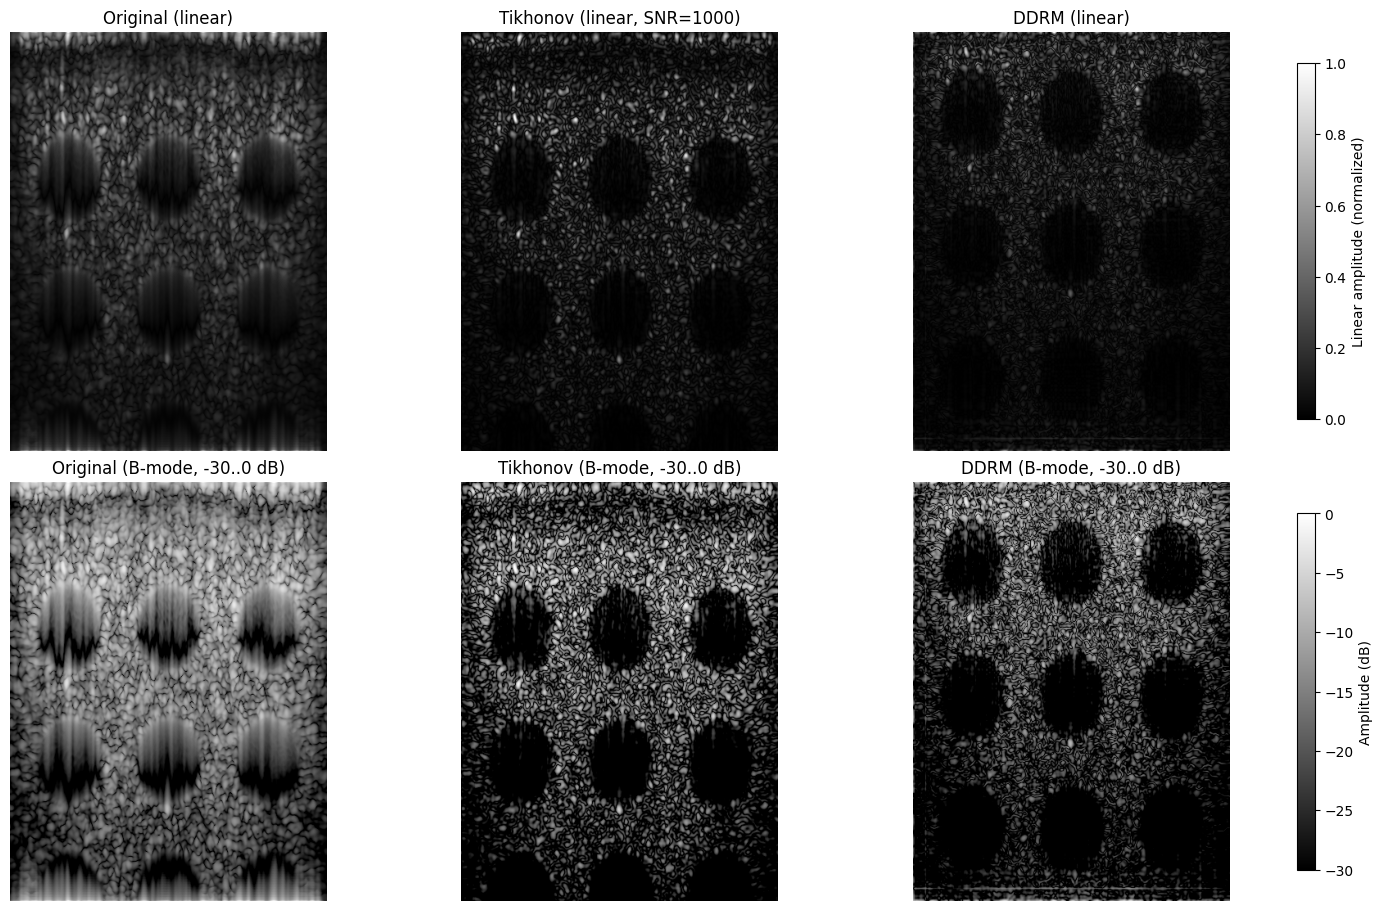

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import hilbert

# -----------------------------
# Compare: Original vs Tikhonov vs DDRM (same visualization as before)
#   - Dataset: exp_data2.mat
#   - PSF:     psf_exp2_oleg.mat
#   - DDRM:    0_-1.mat   (uploaded in this session)
# -----------------------------

# 1) Load RF (original) and PSF
rf = loadmat('exp/datasets/PICMUS/Simulation_Data/picmus_simu1.mat')['data'].astype(float)

psf_mat = loadmat('exp/datasets/PICMUS/Simulation_Data/psf_simu1_oleg.mat')
for k in ('cropped_psf','psf','H','kernel'):
    if k in psf_mat:
        psf = psf_mat[k].astype(float)
        break
else:
    psf = psf_mat[[k for k in psf_mat.keys() if not k.startswith('__')][0]].astype(float)

# 2) Tikhonov (Wiener-like) with SNR=1000 for parity with your last view
rfn = rf / (np.max(np.abs(rf)) + 1e-12)
psf = psf / (np.sum(np.abs(psf)) + 1e-12)
Mh, Nh = psf.shape
M, N = rfn.shape
pad_h = np.zeros_like(rfn)
pad_h[:Mh, :Nh] = psf
pad_h = np.roll(pad_h, -Mh//2, axis=0)
pad_h = np.roll(pad_h, -Nh//2, axis=1)
H = np.fft.fft2(pad_h)
Y = np.fft.fft2(rfn)
SNR_val = 500.0
VivoTK = np.fft.ifft2((np.conjugate(H) * Y) / (np.conjugate(H) * H + (1.0/SNR_val))).real

# 3) DDRM restoration (load & normalize per your snippet)
#    Using the uploaded DDRM file path available here.
ddrm_data = loadmat('exp/image_samples/Picmus_Exp/0_-1.mat')
image = ddrm_data['image'] if 'image' in ddrm_data else ddrm_data[[k for k in ddrm_data if not k.startswith('__')][0]]
if image.ndim == 3:
    image = np.transpose(image, (1, 2, 0))  # CHW -> HWC if needed
grayimage = np.mean(image, axis=2) if image.ndim == 3 else image
grayimage = grayimage / np.max(np.abs(grayimage))  # Normalization

# 4) Envelope detection (linear, no log) and crop to common size
M1, N1 = rf.shape
M2, N2 = VivoTK.shape
M3, N3 = grayimage.shape
Mmin, Nmin = min(M1, M2, M3), min(N1, N2, N3)

rf       = rf[:Mmin, :Nmin]
VivoTK   = VivoTK[:Mmin, :Nmin]
grayimage= grayimage[:Mmin, :Nmin]

env_raw = np.abs(hilbert(rf, axis=0));     env_raw /= (env_raw.max() + 1e-12)
env_tik = np.abs(VivoTK);                  env_tik /= (env_tik.max() + 1e-12)
env_ddr = np.abs(grayimage);               env_ddr /= (env_ddr.max() + 1e-12)

# 5) Log B-mode function
def bmode_db(env, vmin=-30, vmax=0):
    env = env / (env.max() + 1e-12)
    db = 20*np.log10(env + 1e-12)
    return np.clip(db, vmin, vmax)

b_raw = bmode_db(env_raw, vmin=-30, vmax=0)
b_tik = bmode_db(env_tik, vmin=-30, vmax=0)
b_ddr = bmode_db(env_ddr, vmin=-30, vmax=0)

# 6) Same visualization as before: two rows (linear, B-mode), three columns
fig, axes = plt.subplots(2, 3, figsize=(15, 9), constrained_layout=True)

# Top row: linear envelopes
titles_top = ['Original (linear)', 'Tikhonov (linear, SNR=1000)', 'DDRM (linear)']
for j, im in enumerate([env_raw, env_tik, env_ddr]):
    imh_top = axes[0, j].imshow(im, cmap='gray', vmin=0, vmax=1, origin='upper', aspect='equal')
    axes[0, j].set_title(titles_top[j])
    axes[0, j].axis('off')

# Bottom row: B-mode dB
titles_bot = ['Original (B-mode, -30..0 dB)', 'Tikhonov (B-mode, -30..0 dB)', 'DDRM (B-mode, -30..0 dB)']
for j, im in enumerate([b_raw, b_tik, b_ddr]):
    imh_bot = axes[1, j].imshow(im, cmap='gray', vmin=-30, vmax=0, origin='upper', aspect='equal')
    axes[1, j].set_title(titles_bot[j])
    axes[1, j].axis('off')

# Shared colorbars per row
cb0 = fig.colorbar(imh_top, ax=axes[0, :].ravel().tolist(), shrink=0.85)
cb0.set_label('Linear amplitude (normalized)')
cb1 = fig.colorbar(imh_bot, ax=axes[1, :].ravel().tolist(), shrink=0.85)
cb1.set_label('Amplitude (dB)')

plt.show()
